### Recommender System on the Movielens Dataset. 

### Analysis Conducted by Ben Fowler & Shweta Viswanath. 
#### January, 2017

### Introduction:
This analysis will review how users rate movies from the Movielens service. This analysis consits of four sections.

- Section 1: Data Description and Initial Preprocessing
    - Dataset Overview
    - Dataset Description
    - Data Preparation


- Section 2: Data Review and Visualization
    - Review of User Demographics
        - Age
        - Gender
        - Region
    - Review of Movies and Their Ratings
        - Genre
        - 25 Most Rated Movies
        - The Top Rated Movies (with at least 100 ratings)
        - Top 50 Rated Movies by Age
        - Top 50 Rated Movies by Region
        - Moving Ratings by Gender
    - Data Review Conclusions


- Section 3: Recommender System Modeling
    - Data Preprocessing for Recommender System
    - Model 0: Item-Item Recommender System
    - Model 1: User-Item Ranking Recommender System without Tuning
    - Model 2: User-Item Ranking Factorization with Tuning, Before Optimization
    - Model 3: User-Item Ranking Factorization with Tuning and Optimization
    - Model 4: User-Item Factorization Recommender
    - Final Recommender System Model Selection


- Section 4: Association Rule Mining
    - Most Frequent Movie Patterns
    - Association Rules


In [1043]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## Section 1: Data Description and Initial Preprocessing

### Dataset Overview:

The Movielens dataset consists of 1,000,209 movie ratings on approximately 3,090 movies from 6,040 users who joined Movielens in 2000. This dataset is available at: http://www.grouplens.org/. 

### Dataset Description

This data set includes three files:
    
   ##### The ratings file (ratings.dat)

        The ratings file is in the following format:

        UserID::MovieID::Rating::Timestamp

        - UserIDs range between 1 and 6040 
        - MovieIDs range between 1 and 3952
        - Ratings are made on a 5-star scale (whole-star ratings only)
        - Timestamp is represented in seconds since the epoch as returned by time(2)
        - Each user has at least 20 ratings
   
   ##### The users file (users.dat)
        
        The users file is in the following format:
        
        UserID::Gender::Age::Occupation::Zip-code

        All demographic information is provided voluntarily by the users and is
        not checked for accuracy.  Only users who have provided some demographic
        information are included in this data set.

        - Gender is denoted by a "M" for male and "F" for female
        - Age is chosen from the following ranges:

            *  1:  "Under 18"
            * 18:  "18-24"
            * 25:  "25-34"
            * 35:  "35-44"
            * 45:  "45-49"
            * 50:  "50-55"
            * 56:  "56+"

        - Occupation is chosen from the following choices:

            *  0:  "other" or not specified
            *  1:  "academic/educator"
            *  2:  "artist"
            *  3:  "clerical/admin"
            *  4:  "college/grad student"
            *  5:  "customer service"
            *  6:  "doctor/health care"
            *  7:  "executive/managerial"
            *  8:  "farmer"
            *  9:  "homemaker"
            * 10:  "K-12 student"
            * 11:  "lawyer"
            * 12:  "programmer"
            * 13:  "retired"
            * 14:  "sales/marketing"
            * 15:  "scientist"
            * 16:  "self-employed"
            * 17:  "technician/engineer"
            * 18:  "tradesman/craftsman"
            * 19:  "unemployed"
            * 20:  "writer"

###### The movies file (movies.dat)

        The movies file is in the following format:

        MovieID::Title::Genres

        - Titles are identical to titles provided by the IMDB (including
        year of release)
        - Genres are pipe-separated and are selected from the following genres:

            * Action
            * Adventure
            * Animation
            * Children's
            * Comedy
            * Crime
            * Documentary
            * Drama
            * Fantasy
            * Film-Noir
            * Horror
            * Musical
            * Mystery
            * Romance
            * Sci-Fi
            * Thriller
            * War
            * Western

        - Some MovieIDs do not correspond to a movie due to accidental duplicate
        entries and/or test entries
        - Movies are mostly entered by hand, so errors and inconsistencies may exist

### Data Preparation

- 656 users in the dataset had a zipcode with 3 or 4 digits. Since these values are not correct, these values were dropped. 

- The zip code was truncated to the first digit (0-9). The first digit designates the general area of the country with numbers starting lower in the east and increasing as you move west. For example 0 covers Maine while 9 refers to California. This column was relabeled as region. 

- 197 movies were removed from the movies file, due to incorrect data entry in the original file.

In [1138]:
import numpy as np
import pandas as pd
import graphlab as gl
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline
from matplotlib.colors import ListedColormap
import seaborn as sns
cmap = sns.diverging_palette(200,10, as_cmap=True)

In [1139]:
movies_df = pd.read_csv('movie_ratings_cleaned.csv')
movietitles_df = pd.read_csv('movies.csv')
users_df = pd.read_csv('users.csv')

In [1140]:
users_df.rename(columns={'zip_trunc': 'region'}, inplace=True)

In [1141]:
movies_df.head()

,rating_id,user,movie_ID,rating,movie,genre
0,1,1,1193,5,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1,661,3,James and the Giant Peach (1996),Animation|Children's|Musical
2,3,1,914,3,My Fair Lady (1964),Musical|Romance
3,4,1,3408,4,Erin Brockovich (2000),Drama
4,5,1,2355,5,"Bug's Life, A (1998)",Animation|Children's|Comedy


In [1142]:
movietitles_df.head()

,movie_ID,movie,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [1143]:
users_df.head()

,user,gender,age,occupation,zip_code,region
0,5454,M,35,7,10001,1
1,1256,M,25,20,10002,1
2,1517,M,18,0,10002,1
3,1597,M,25,12,10002,1
4,1845,M,25,2,10002,1


In [1144]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 936381 entries, 0 to 936380
Data columns (total 6 columns):
rating_id    936381 non-null int64
user         936381 non-null int64
movie_ID     936381 non-null int64
rating       936381 non-null int64
movie        936381 non-null object
genre        936381 non-null object
dtypes: int64(4), object(2)
memory usage: 42.9+ MB


In [1145]:
movietitles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3686 entries, 0 to 3685
Data columns (total 3 columns):
movie_ID    3686 non-null int64
movie       3686 non-null object
genre       3686 non-null object
dtypes: int64(1), object(2)
memory usage: 86.5+ KB


In [1146]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5384 entries, 0 to 5383
Data columns (total 6 columns):
user          5384 non-null int64
gender        5384 non-null object
age           5384 non-null int64
occupation    5384 non-null int64
zip_code      5384 non-null object
region        5384 non-null int64
dtypes: int64(4), object(2)
memory usage: 252.4+ KB


In [1147]:
del users_df['zip_code']

In [1148]:
movietitles_df = pd.concat([movietitles_df.movie_ID, movietitles_df.movie, movietitles_df.genre.str.get_dummies(sep='|')], axis=1)
movietitles_df.movie_ID.astype(int)
movietitles_df.head()

,movie_ID,movie,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [1149]:
# create one merged DataFrame
movie_ratings = pd.merge(movietitles_df, movies_df)
merged_df = pd.merge(movie_ratings, users_df)
merged_df.head()

,movie_ID,movie,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,...,War,Western,rating_id,user,rating,genre,gender,age,occupation,region
0,1,Toy Story (1995),0,0,1,1,1,0,0,0,...,0,0,41,1,5,Animation|Children's|Comedy,F,1,10,4
1,48,Pocahontas (1995),0,0,1,1,0,0,0,0,...,0,0,26,1,5,Animation|Children's|Musical|Romance,F,1,10,4
2,150,Apollo 13 (1995),0,0,0,0,0,0,0,1,...,0,0,40,1,5,Drama,F,1,10,4
3,527,Schindler's List (1993),0,0,0,0,0,0,0,1,...,1,0,24,1,5,Drama|War,F,1,10,4
4,531,"Secret Garden, The (1993)",0,0,0,1,0,0,0,1,...,0,0,50,1,4,Children's|Drama,F,1,10,4


## Section 2: Data Review and Visualization

### Review of User Demographics:

#### Age:

Age is binned in the following ranges:

*  1 =  "Under 18"
* 18 =  "18-24"
* 25 =  "25-34"
* 35 =  "35-44"
* 45 =  "45-49"
* 50 =  "50-55"
* 56 =  "56+"

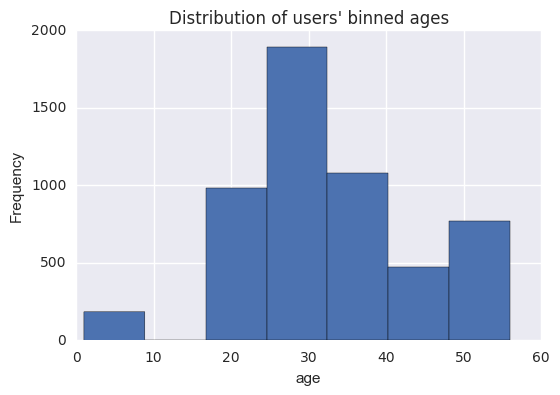

In [1150]:
plt.title("Distribution of users' binned ages")
plt.ylabel('count of users')
plt.xlabel('age');
users_df.age.plot.hist(bins=7)

##### Table of counts of ratings and average rating by binned age group

In [1030]:
merged_df.groupby('age').agg({'rating': [np.size, np.mean]})

rating          
       size      mean
age                  
1     20145  3.569422
18   153215  3.511223
25   329672  3.547147
35   169292  3.630414
45    68272  3.634799
50    62316  3.727052
56    32589  3.770567

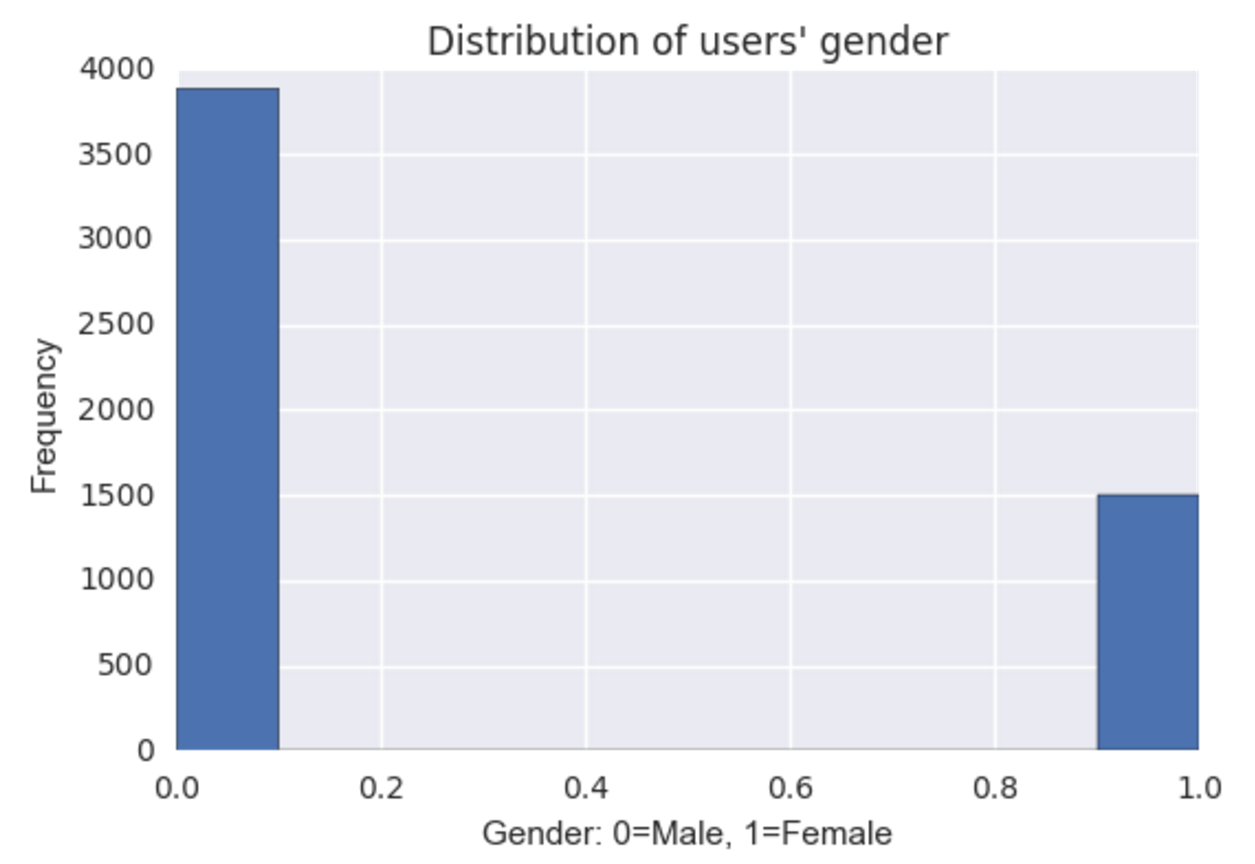

In [1054]:
from IPython.display import Image
PATH = "C:/Users/DM/"
Image(filename = PATH + "gender.png", width=500, height=500)

#### Gender:
##### Table of counts of ratings and average rating by gender

In [1013]:
merged_df.groupby('gender').agg({'rating': [np.size, np.mean]})

rating          
          size      mean
gender                  
F       204756  3.621261
M       630745  3.576227

#### Region:
##### Region Distribution of Users:

The 1st digit of the zip code, from the column "zip_trunc" represents users in the following states:
- 0 = Connecticut (CT), Massachusetts (MA), Maine (ME), New Hampshire (NH), New Jersey (NJ), Puerto Rico (PR), Rhode Island (RI), Vermont (VT), Virgin Islands (VI)
- 1 = Delaware (DE), New York (NY), Pennsylvania (PA)
- 2 = District of Columbia (DC), Maryland (MD), North Carolina (NC), South Carolina (SC), Virginia (VA), West Virginia (WV)
- 3 = Alabama (AL), Florida (FL), Georgia (GA), Mississippi (MS), Tennessee (TN)
- 4 = Indiana (IN), Kentucky (KY), Michigan (MI), Ohio (OH)
- 5 = Iowa (IA), Minnesota (MN), Montana (MT), North Dakota (ND), South Dakota (SD), Wisconsin (WI)
- 6 = Illinois (IL), Kansas (KS), Missouri (MO), Nebraska (NE)
- 7 = Arkansas (AR), Louisiana (LA), Oklahoma (OK), Texas (TX)
- 8 = Arizona (AZ), Colorado (CO), Idaho (ID), New Mexico (NM), Nevada (NV), Utah (UT), Wyoming (WY)
- 9 = Alaska (AK), American Samoa (AS), California (CA), Guam (GU), Hawaii (HI), Oregon (OR), Washington (WA)

#### Below is the distibution of ratings from users in the 10 regions with the mean rating from each region:

In [977]:
merged_df.groupby('region').agg({'rating': [np.size, np.mean]})

rating          
          size      mean
region                  
0          491  3.881874
1        97944  3.588306
2        70309  3.610903
3        58971  3.557274
4        90219  3.572197
5        92558  3.624408
6        75685  3.533448
7        66607  3.612999
8        49262  3.507288
9       233455  3.604738

### Review of Movies and their Ratings:

#### Genre:
##### Table of counts of ratings and average rating by genre

In [1151]:
merged_df.groupby('genre').agg({'rating': [np.size, np.mean]})

rating          
                                                size      mean
genre                                                         
Action                                         10886  3.363311
Action|Adventure                                9269  3.687021
Action|Adventure|Animation                       309  4.142395
Action|Adventure|Animation|Children's|Fantasy    120  2.741667
Action|Adventure|Animation|Horror|Sci-Fi         564  3.547872
Action|Adventure|Children's|Comedy               468  2.309829
Action|Adventure|Children's|Fantasy               41  2.097561
Action|Adventure|Children's|Sci-Fi               321  1.847352
Action|Adventure|Comedy                         1897  3.093305
Action|Adventure|Comedy|Crime                   2321  3.136148
Action|Adventure|Comedy|Horror                   491  3.828921
Action|Adventure|Comedy|Horror|Sci-Fi            860  3.795349
Action|Adventure|Comedy|Romance                 5160  3.863372
Action|Adventure|Comedy|Sci-Fi                  2286  3.733158
Action|Adventure|Comedy|War                      189  2.264550
Action|Adventure|Crime                          1683  2.932858
Action|Adventure|Crime|Drama                    1274  3.622449
Action|Adventure|Crime|Thriller                  203  2.763547
Action|Adventure|Drama                          1473  3.263408
Action|Adventure|Drama|Romance                   332  2.921687
Action|Adventure|Drama|Thriller                  190  3.415789
Action|Adventure|Fantasy                        1684  3.277316
Action|Adventure|Fantasy|Sci-Fi                  875  3.361143
Action|Adventure|Horror                         1755  3.378348
Action|Adventure|Horror|Thriller                 908  3.320485
Action|Adventure|Mystery                         341  3.410557
Action|Adventure|Mystery|Sci-Fi                  517  2.234043
Action|Adventure|Romance                        1028  3.417315
Action|Adventure|Romance|Thriller               1360  3.023529
Action|Adventure|Romance|War                     931  4.252417
...                                              ...       ...
Film-Noir|Mystery|Thriller                      1648  3.941748
Film-Noir|Romance|Thriller                       393  4.312977
Film-Noir|Sci-Fi                                1612  4.273573
Film-Noir|Sci-Fi|Thriller                        795  3.816352
Film-Noir|Thriller                              1767  4.220713
Horror                                         16702  3.236080
Horror|Mystery                                    95  2.778947
Horror|Mystery|Thriller                         1824  2.904057
Horror|Romance                                  1729  3.454020
Horror|Sci-Fi                                   6789  3.051554
Horror|Sci-Fi|Thriller                          1253  2.802075
Horror|Thriller                                 7308  3.244800
Musical                                         2882  3.794587
Musical|Romance                                 2815  3.946359
Musical|Romance|War                              256  3.574219
Musical|War                                      401  3.907731
Mystery                                         1031  3.783705
Mystery|Romance|Thriller                         849  3.578327
Mystery|Sci-Fi                                   474  3.451477
Mystery|Thriller                                5913  3.892779
Romance                                         1757  3.375640
Romance|Thriller                                 497  3.865191
Romance|War                                      115  3.347826
Romance|Western                                   59  3.627119
Sci-Fi                                          4587  3.587748
Sci-Fi|Thriller                                 4174  3.051030
Sci-Fi|Thriller|War                              250  3.436000
Thriller                                       15925  3.546813
War                                              870  3.902299
Western                                         5190  3.863391

[293 rows x 2

#### Below are the 25 most rated movies:

In [978]:
most_rated = merged_df.groupby('movie').size().sort_values(ascending=False)[:25]
most_rated

movie
American Beauty (1999)               3039
Jurassic Park (1993)                 2390
Saving Private Ryan (1998)           2378
Matrix, The (1999)                   2329
Silence of the Lambs, The (1991)     2291
Men in Black (1997)                  2286
Back to the Future (1985)            2284
Fargo (1996)                         2250
Raiders of the Lost Ark (1981)       2226
Braveheart (1995)                    2212
Sixth Sense, The (1999)              2206
Shakespeare in Love (1998)           2083
Princess Bride, The (1987)           2081
Schindler's List (1993)              2060
L.A. Confidential (1997)             2033
Groundhog Day (1993)                 2028
E.T. the Extra-Terrestrial (1982)    2027
Being John Malkovich (1999)          1983
Godfather, The (1972)                1981
Shawshank Redemption, The (1994)     1977
Forrest Gump (1994)                  1958
Ghostbusters (1984)                  1943
Pulp Fiction (1994)                  1923
Terminator, The (1984)      

#### The top rated movies with at least 100 ratings

In [979]:
movie_stats = merged_df.groupby('movie').agg({'rating': [np.size, np.mean]})
movie_stats.head()
# sort by rating average
movie_stats.sort_values([('rating', 'mean')], ascending=False).head()
atleast_100 = movie_stats['rating']['size'] >= 100
movie_stats[atleast_100].sort_values([('rating', 'mean')], ascending=False)[:15]

rating          
                                                     size      mean
movie                                                              
Seven Samurai (The Magnificent Seven) (Shichini...    554  4.557762
Shawshank Redemption, The (1994)                     1977  4.554375
Godfather, The (1972)                                1981  4.521454
Close Shave, A (1995)                                 561  4.518717
Wrong Trousers, The (1993)                            756  4.518519
Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)         420  4.516667
Schindler's List (1993)                              2060  4.508252
Usual Suspects, The (1995)                           1577  4.497146
Paths of Glory (1957)                                 202  4.495050
Rear Window (1954)                                    936  4.480769
Raiders of the Lost Ark (1981)                       2226  4.473495
Third Man, The (1949)                                 431  4.459397
To Kill a Mockingbird (1962)                          820  4.446341
Yojimbo (1961)                                        193  4.430052
Double Indemnity (1944)                               499  4.424850

#### The top 50 rated movies by binned age groups:

In [1153]:
most_50 = merged_df.groupby('movie_ID').size().sort_values(ascending=False)[:50]
merged_df.set_index('movie_ID', inplace=True)
by_age = merged_df.loc[most_50.index].groupby(['movie', 'age'])

In [1154]:
by_age.rating.mean().unstack(1).fillna(0)[0:50]

age,1,18,25,35,45,50,56
movie,,,,,,,
"Abyss, The (1989)",3.821429,3.913621,3.638095,3.693291,3.692308,3.520000,3.565217
Airplane! (1980),3.718750,4.068441,4.003125,3.901961,3.952000,3.970874,3.777778
Alien (1979),3.939394,3.919118,4.253501,4.210900,4.167665,4.106383,4.065574
Aliens (1986),4.000000,4.139785,4.179340,4.136364,4.106557,3.845455,3.788462
American Beauty (1999),4.410256,4.526232,4.328607,4.242593,4.116279,4.126126,4.121795
Babe (1995),3.238806,3.634538,3.956822,4.014663,4.021898,3.974138,3.971429
Back to the Future (1985),4.075472,4.080760,3.941769,3.993644,3.983784,4.046512,3.931818
Being John Malkovich (1999),4.075472,4.222222,4.085575,4.174157,4.120301,3.992000,4.093333
Blade Runner (1982),4.000000,4.059072,4.345865,4.318421,4.273438,4.181034,4.322581


#### The top 50 rated movies by region:

In [986]:
by_region = merged_df.loc[most_50.index].groupby(['movie', 'region'])
by_region.rating.mean().head(15)
by_region.rating.mean().unstack(1).fillna(0)[0:50]

region,0,1,2,3,4,5,6,7,8,9
movie,,,,,,,,,,
"Abyss, The (1989)",5.000000,3.643312,3.637097,3.669355,3.595092,3.683230,3.727941,3.744526,3.867347,3.731544
Airplane! (1980),0.000000,3.988764,3.813953,3.972727,3.771739,4.025773,4.149254,3.938596,3.977011,4.026764
Alien (1979),3.000000,4.138462,4.169697,4.172662,4.162562,4.000000,4.028369,4.234043,4.165138,4.250000
Aliens (1986),0.000000,4.145946,4.089041,4.212389,4.050847,4.010417,4.120301,4.223022,4.139785,4.135076
American Beauty (1999),3.000000,4.250000,4.197674,4.183246,4.374593,4.250696,4.364341,4.428571,4.479042,4.342825
Babe (1995),5.000000,3.803468,4.049180,3.866667,3.793651,3.792553,3.808333,3.966102,3.817073,3.993492
Back to the Future (1985),5.000000,4.064516,3.882353,4.012500,4.054945,4.000000,3.994652,3.878453,4.094891,3.967577
Being John Malkovich (1999),0.000000,4.153257,4.097561,3.980769,4.081081,4.050209,4.123457,4.075472,4.184211,4.198319
Blade Runner (1982),3.000000,4.306011,4.280303,4.230769,4.169811,4.091371,4.280000,4.263566,4.307692,4.372709


#### How do movie ratings compare between men and women?

In [1009]:
merged_df.reset_index('movie_ID', inplace=True)
pivoted = merged_df.pivot_table(index=['movie_ID', 'movie'],
                           columns=['gender'],
                           values='rating',
                           fill_value=0)
pivoted['diff'] = pivoted.M - pivoted.F
pivoted.head()

,gender,F,M,diff
movie_ID,movie,,,
1,Toy Story (1995),4.207767,4.129880,-0.077887
2,Jumanji (1995),3.288462,3.197895,-0.090567
3,Grumpier Old Men (1995),3.056452,3.000000,-0.056452
4,Waiting to Exhale (1995),2.948718,2.533333,-0.415385
5,Father of the Bride Part II (1995),3.221053,2.882353,-0.338700


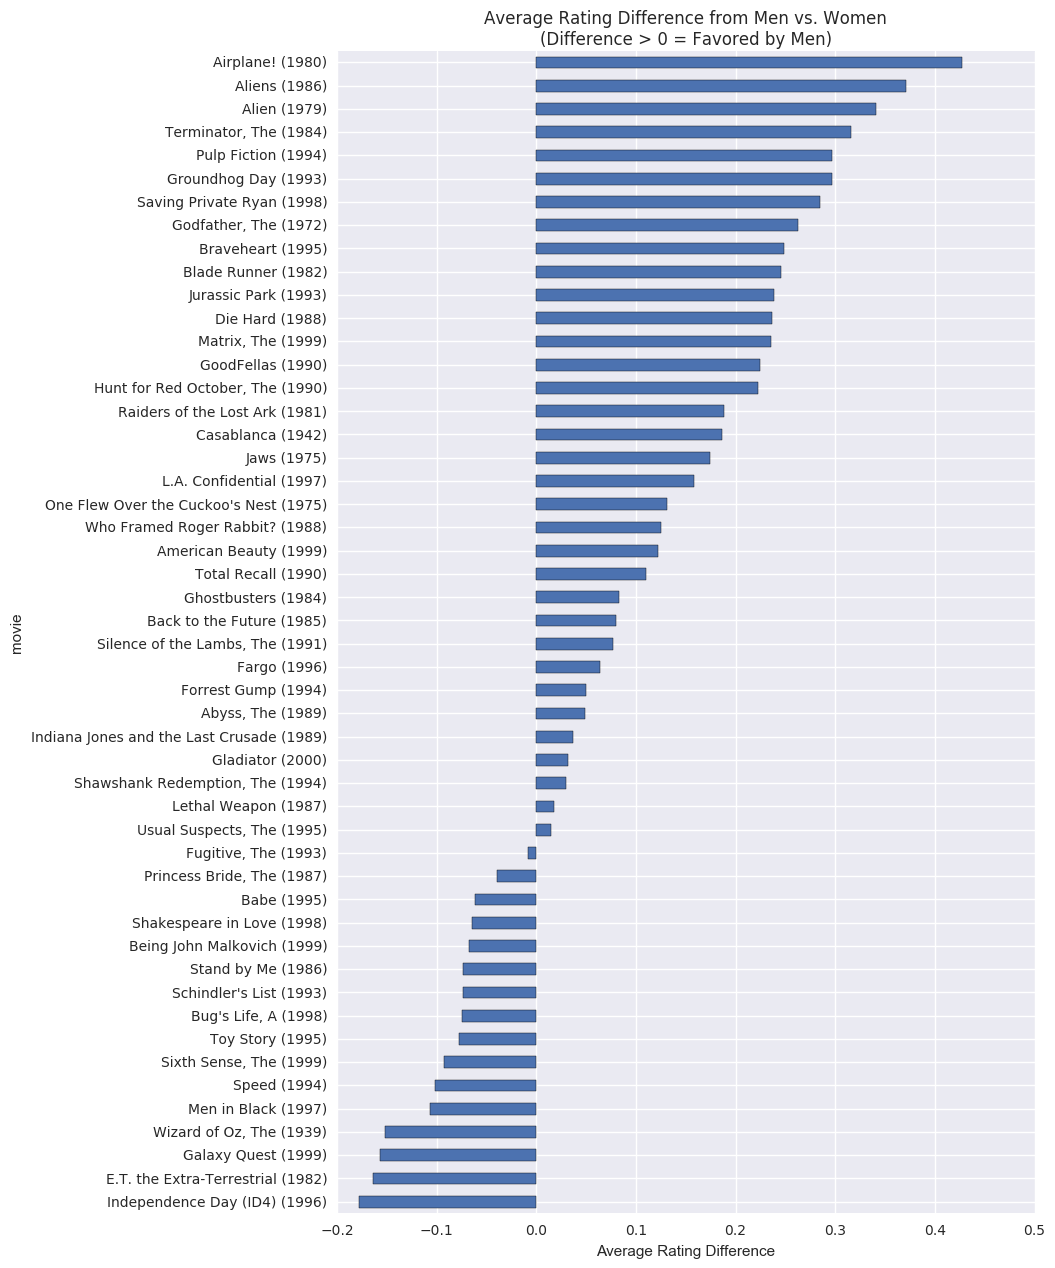

In [1010]:
pivoted.reset_index('movie_ID', inplace=True)
disagreements = pivoted[pivoted.movie_ID.isin(most_50.index)]['diff']
disagreements.sort_values().plot(kind='barh', figsize=[9, 15])
plt.title('Average Rating Difference from Men vs. Women\n(Difference > 0 = Favored by Men)')
plt.ylabel('movie')
plt.xlabel('Average Rating Difference');

### Data Review Conclusions:

- Generally, users are middle aged
- Men outnumber women users by over a 2:1 ratio
- Nearly a quarter of all ratings came from the pacific region.
- Men significantly prefer Airplane, Aliens, Alien and The Terminator over women
- Women significantly prefer Independence Day, E.T. the Extra-Terrestrial, Galaxy Quest and The Wizard of Oz over Men.

## Section 3: Recommender System Modeling

### Data Preprocessing for Recommender System

In [1032]:
# Create a set of dummy variables from the gender variable
gender = pd.get_dummies(users_df['gender'])
users_df = pd.concat([users_df, gender.astype(int)], axis=1)
del users_df['gender']
age = pd.get_dummies(users_df['age'])
users_df = pd.concat([users_df, age.astype(int)], axis=1)
del users_df['age']
occupation = pd.get_dummies(users_df['occupation'])
users_df = pd.concat([users_df, occupation.astype(int)], axis=1)
del users_df['occupation']
zip_trunc = pd.get_dummies(users_df['region'])
users_df = pd.concat([users_df, zip_trunc.astype(int)], axis=1)
del users_df['region']

In [1052]:
#plt.title("Distribution of users' gender")
#plt.ylabel('count of users')
#plt.xlabel('Gender: 0=Male, 1=Female');
#users_df.F.plot.hist(bins=10)

In [895]:
movietitles_df.to_csv('ratings_with_dummies.csv')
users_df.to_csv('users_with_dummies')

In [896]:
# This is a well known graphlab example that builds a recommendation system in 5 lines of code
data = gl.SFrame.read_csv("movie_ratings_cleaned.csv",
                          column_type_hints={"rating_id":int, "user":int, "movie_ID":int, "rating":int,"movie":str, "genre":str})
genre = gl.SFrame.read_csv("ratings_with_dummies2.csv",
                          column_type_hints={"Action":int, "Adventure":int, "Animation":int, "Children's":int, "Comedy":int,\
                                             "Crime":int, "Documentary":int, "Drama":int, "Fantasy":int, "Film-Noir":int,\
                                            "Horror":int, "Musical":int, "Mystery":int, "Romance":int, "Sci-Fi":int,\
                                            "Thriller":int, "War":int, "Western":int})
users = gl.SFrame.read_csv("users_with_dummies.csv",
                          column_type_hints={"user":int, "F":int, "M":int, 'Under_18':int,\
                                             "18-24":int, "25-34":int, "35-44":int, "45-49":int, "50-55": int,\
                                            "Over_56":int, "Other":int, "Academic/Educator":int, "Artist":int,\
                                            "Clerical/Admin":int, "College/Grad_Student":int, "Customer_Service":int,\
                                            "Doctor/Health_Care":int, "Executive/Managerial":int, "Farmer":int,\
                                            "Homemaker":int, "K-12_Student":int, "Lawyer":int, "Programmer":int,\
                                            "Retired":int, "Sales/Marketing":int, "Scientist":int, "Self_Employed":int,\
                                            "Technician/Engineer":int, "Tradesman/Craftsman":int, "Unemployed":int,\
                                            "Writer":int, "New_England": int, "Northeast": int, "Mid_Atlantic": int,\
                                            "Southeast":int, "Eastern_Midwest":int, "Upper_Midwest":int, "Midwest":int,\
                                            "South_Central":int, "Rocky_Mountain":int, "Pacific":int})




Finished parsing file C:\Users\Ben Fowler\Documents\Jupyter Notebooks\movie_ratings_cleaned.csv

Parsing completed. Parsed 100 lines in 1.65364 secs.

Read 896138 lines. Lines per second: 720045

Finished parsing file C:\Users\Ben Fowler\Documents\Jupyter Notebooks\movie_ratings_cleaned.csv

Parsing completed. Parsed 936381 lines in 1.26663 secs.

Finished parsing file C:\Users\Ben Fowler\Documents\Jupyter Notebooks\ratings_with_dummies2.csv

Parsing completed. Parsed 100 lines in 0.02258 secs.

Finished parsing file C:\Users\Ben Fowler\Documents\Jupyter Notebooks\ratings_with_dummies2.csv

Parsing completed. Parsed 3686 lines in 0.02607 secs.

Finished parsing file C:\Users\Ben Fowler\Documents\Jupyter Notebooks\users_with_dummies.csv

Parsing completed. Parsed 100 lines in 0.050634 secs.

These column type hints were not used: zip_trunc

Finished parsing file C:\Users\Ben Fowler\Documents\Jupyter Notebooks\users_with_dummies.csv

Parsing completed. Parsed 5384 lines in 0.050634 secs.

In [897]:
data.head()

rating_id,user,movie_ID,rating,movie,genre
1,1,1193,5,One Flew Over theCuckoo's Nest (1975) ...,Drama
2,1,661,3,James and the Giant Peach(1996) ...,Animation|Children's|Musical ...
3,1,914,3,My Fair Lady (1964),Musical|Romance
4,1,3408,4,Erin Brockovich (2000),Drama
5,1,2355,5,"Bug's Life, A (1998)",Animation|Children's|Comedy ...
6,1,1197,3,"Princess Bride, The(1987) ...",Action|Adventure|Comedy|Romance ...
7,1,1287,5,Ben-Hur (1959),Action|Adventure|Drama
8,1,2804,5,"Christmas Story, A (1983)",Comedy|Drama
9,1,594,4,Snow White and the SevenDwarfs (1937) ...,Animation|Children's|Musical ...
10,1,919,4,"Wizard of Oz, The (1939)",Adventure|Children's|Drama|Musical ...


In [898]:
genre.head()

movie_ID,movie,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama
1,Toy Story (1995),0,0,1,1,1,0,0,0
2,Jumanji (1995),0,1,0,1,0,0,0,0
3,Grumpier Old Men (1995),0,0,0,0,1,0,0,0
4,Waiting to Exhale (1995),0,0,0,0,1,0,0,1
5,Father of the Bride PartII (1995) ...,0,0,0,0,1,0,0,0
6,Heat (1995),1,0,0,0,0,1,0,0
7,Sabrina (1995),0,0,0,0,1,0,0,0
8,Tom and Huck (1995),0,1,0,1,0,0,0,0
9,Sudden Death (1995),1,0,0,0,0,0,0,0
10,GoldenEye (1995),1,1,0,0,0,0,0,0


In [899]:
users.head()

user,F,M,Under_18,18-24,25-34,35-44,45-49,50-55,Over_56,Other,Academic/Educator,Artist,Clerical/Admin
5454,0,1,0,0,0,1,0,0,0,0,0,0,0
1256,0,1,0,0,1,0,0,0,0,0,0,0,0
1517,0,1,0,1,0,0,0,0,0,1,0,0,0
1597,0,1,0,0,1,0,0,0,0,0,0,0,0
1845,0,1,0,0,1,0,0,0,0,0,0,1,0
3110,0,1,0,0,1,0,0,0,0,1,0,0,0
283,0,1,0,0,1,0,0,0,0,1,0,0,0
1581,1,0,0,1,0,0,0,0,0,0,0,0,0
1629,0,1,0,1,0,0,0,0,0,0,0,0,0
2822,0,1,0,0,0,0,0,1,0,0,0,0,0


We will  create a holdout set for cross validation of the data set to see what model and model parameters actually generalize well with out dataset. That also means we need a set of evaluation criteria. The first and very common measuer is the root mean squared error, RMSE. It takes into account the difference between the predicted rating and the actual rating of items. 

RMSE can be calculated in a number of different aggregated ways (i.e., splits and aggregation). Some ways include:
    - Calculating the average RMSE of every entry in the dataset. 
    - Calculating the average RMSE for each user.
    - Calculating the average RMSE for each item.

So let's now create a holdout set and see if we can judge the RMSE on a per-item and per-user basis to find the best model for our recommender system.

In [1070]:
train, test = gl.recommender.util.random_split_by_user(data,
                                                    user_id="user", item_id="movie",
                                                    max_num_users=100, item_test_proportion=0.2)

### Model 0: Item-Item Collaborative Filtering Recommender System

Now let's look at creating the item-item similarity matrix. That is, for each item, what are the top closest items based upon user ratings.

In [1071]:
from IPython.display import display
from IPython.display import Image

gl.canvas.set_target('ipynb')


item_item = gl.recommender.item_similarity_recommender.create(train, 
                                  user_id="user", 
                                  item_id="movie", 
                                  target="rating",
                                  item_data=genre,
                                  user_data=users,
                                  only_top_k=5,
                                  similarity_type="cosine")

rmse_results = item_item.evaluate(test)

Recsys training: model = item_similarity

Warning: Ignoring columns rating_id, movie_ID, genre;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 933461 observations with 6040 users and 3732 items.

Data prepared in: 1.31852s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 7.02ms                         | 16.5       |

| 45.12ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 67.68ms                             | 0                | 0               |

| 1.06s                               | 57.25            | 2140            |

| 1.88s                               | 100              | 3732            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 2.17452s


Precision and recall summary statistics by cutoff
+--------+----------------+-----------------+
| cutoff | mean_precision |   mean_recall   |
+--------+----------------+-----------------+
|   1    |      0.38      | 0.0232623326535 |
|   2    |      0.36      | 0.0406010643261 |
|   3    | 0.363333333333 | 0.0545103788212 |
|   4    |     0.335      | 0.0638115648336 |
|   5    |     0.324      | 0.0819640068196 |
|   6    |     0.315      | 0.0947756968356 |
|   7    | 0.308571428571 |  0.104038119814 |
|   8    |      0.3       |  0.111740387834 |
|   9    | 0.292222222222 |  0.119455292686 |
|   10   |      0.28      |  0.126099223734 |
+--------+----------------+-----------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 3.7839137766989275)

Per User RMSE (best)
+------+-------+---------------+
| user | count |      rmse     |
+------+-------+---------------+
| 5243 |   2   | 2.23125476292 |
+------+-------+---------------+
[1 rows x 3 columns]


Per User RMSE (worst)
+------+-

##### Below is the RMSE for each item in the dataset. 

- None of these movies with the item-item model have a particularly good RMSE, suggesting this model may not be effective for this dataset. 

In [1072]:
print rmse_results.viewkeys()
print rmse_results['rmse_by_item']

dict_keys(['rmse_by_user', 'precision_recall_overall', 'rmse_by_item', 'precision_recall_by_user', 'rmse_overall'])
+-------------------------------+-------+---------------+
|             movie             | count |      rmse     |
+-------------------------------+-------+---------------+
|    Parent Trap, The (1998)    |   1   | 3.98038202922 |
|        Sneakers (1992)        |   4   | 3.77281409661 |
| Much Ado About Nothing (1993) |   5   | 4.46920605518 |
|          X-Men (2000)         |   7   | 3.76275911101 |
|       Dead Again (1991)       |   2   | 3.80788655293 |
| Truth About Cats & Dogs, T... |   2   | 3.53206204568 |
|    On the Waterfront (1954)   |   2   | 4.96185035326 |
|      Men With Guns (1997)     |   1   |      3.0      |
|    Ruby in Paradise (1993)    |   2   | 4.52566827987 |
|  Raisin in the Sun, A (1961)  |   1   |      5.0      |
+-------------------------------+-------+---------------+
[1333 rows x 3 columns]
Note: Only the head of the SFrame is printed.
Yo

##### Below is the RMSE for each user in the dataset. 

- None of these users have a particularly good RMSE in the item-item model, providing further evidence that this is not  a good model for this dataset. 

In [1074]:
rmse_results['rmse_by_user']

user,count,rmse
5021,39,3.78303102169
5893,22,3.8435170185
696,76,3.92603235454
578,5,4.23189077588
521,7,3.91303737913
5511,145,4.2847328094
1337,18,3.92031527637
4008,3,3.56952372712
4367,23,3.69875806778
852,7,3.93437795347


#### Recall and Precision

Another evaluation criterion is the per-user-recall or the per-user-precision. These are typically smaller values because they require users with a large number of ratings. The idea behind them is that, given a number of highly rated items for a user, how many of them did my model also recommend. 

This is inherently difficult to calculate because the user has not rated every item in the dataset---we may have found 10 items that the user would have chosen and rated highly, but if the user never rated them, we can't be sure how good we are recommending them. 

Even still, its a good measure of how well you are rating the items that are most important to the user (assuming the user rated items they had strong opinions about). Its not perfect, but its the best we have to work with.

The per-user-recall relates to the idea "of all the items rated positively by the user, how many did your recommender find?"

The per-user-precision relates to the idea "of the k items found by your recommender, how many were rated positively by the user?"

___
Recall and precision work best in a binary classification data set (i.e. Thumbs up / Thumbs Down), where there is only one prediction.

#####  RMSE works best when predicting a value amongst a range of continous values. Since our ratings in the MovieLens dataset are on continuous scale, RMSE is the measure used to identify the best model for the recommender system.

### Model 1: User-Item Ranking Factorization Without Tuning

In [1077]:
rec1 = gl.recommender.ranking_factorization_recommender.create(train, 
                                  user_id="user", 
                                  item_id="movie", 
                                  target="rating",
                                  item_data=genre,
                                  user_data=users)

rmse_results = rec1.evaluate(test)

Recsys training: model = ranking_factorization_recommender

Preparing data set.

Data has 933461 observations with 6040 users and 3732 items.

Data prepared in: 1.8255s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 32       |

| regularization                 | L2 Regularization on Factors                     | 1e-009   |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-009   |

| ranking_regularization         | Rank-based Regularization Weight                 | 0.25     |

| side_data_factorization        | Assign Factors for Side Data                     | True     |

| max_iterations                 | Maximum Number of Iterations                     | 25       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 116682 / 933461 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 1                 | Not Viable                               |

| 1       | 0.25              | Not Viable                               |

| 2       | 0.0625            | Not Viable                               |

| 3       | 0.015625          | Not Viable                               |

| 4       | 0.00390625        | No Decrease (2.41703 >= 2.39684)         |

| 5       | 0.000976562       | 2.22937                                  |

| 6       | 0.000488281       | 2.31289                                  |

| 7       | 0.000244141       | 2.34643                                  |

| 8       | 0.00012207        | 2.37092                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.000976562       | 2.22937                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 0us          | 2.39904           | 1.10612               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 21.65s       | 2.3015            | 1.10953               | 0.000976562 |

| 2       | 43.04s       | 2.24088           | 1.12845               | 0.000976562 |

| 3       | 1m 0s        | 2.25126           | 1.14448               | 0.000976562 |

| 4       | 1m 18s       | 2.23332           | 1.15626               | 0.000976562 |

| 5       | 1m 36s       | 2.34718           | 1.20906               | 0.000976562 |

| 6       | 1m 55s       | 2.38866           | 1.23606               | 0.000976562 |

| 7       | 2m 17s       | 2.47349           | 1.26221               | 0.000976562 |

| 8       | 2m 35s       | 2.65148           | 1.3429                | 0.000976562 |

| 9       | 3m 0s        | 2.7165            | 1.3614                | 0.000976562 |

| 10      | 3m 26s       | 2.85079           | 1.41036               | 0.000976562 |

| 11      | 3m 44s       | 3.17323           | 1.51109               | 0.000976562 |

| 12      | 4m 20s       | DIVERGED          | DIVERGED              | 0.000976562 |

| RESET   | 4m 27s       | 2.39933           | 1.10613               |             |

| 1       | 4m 49s       | 2.33178           | 1.09728               | 0.000488281 |

| 2       | 5m 7s        | 2.2651            | 1.09174               | 0.000488281 |

| 3       | 5m 26s       | 2.2253            | 1.09059               | 0.000488281 |

| 4       | 5m 45s       | 2.19328           | 1.09012               | 0.000488281 |

| 5       | 6m 8s        | 2.17469           | 1.09028               | 0.000488281 |

| 6       | 6m 25s       | 2.15982           | 1.09202               | 0.000488281 |

| 7       | 6m 45s       | 2.1442            | 1.0928                | 0.000488281 |

| 8       | 7m 7s        | 2.13922           | 1.09618               | 0.000488281 |

| 9       | 7m 26s       | 2.13086           | 1.09652               | 0.000488281 |

| 10      | 7m 48s       | 2.12626           | 1.10118               | 0.000488281 |

| 11      | 8m 7s        | 2.1176            | 1.10124               | 0.000488281 |

| 12      | 8m 26s       | 2.11548           | 1.10331               | 0.000488281 |

| 13      | 8m 46s       | 2.11671           | 1.10822               | 0.000488281 |

| 14      | 9m 6s        | 2.11314           | 1.11193               | 0.000488281 |

| 15      | 3h 45m       | 2.11413           | 1.11466               | 0.000488281 |

| 16      | 3h 46m       | 2.12075           | 1.12326               | 0.000488281 |

| 17      | 3h 46m       | 2.12425           | 1.12634               | 0.000488281 |

| 18      | 3h 46m       | 2.12877           | 1.13139               | 0.000488281 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached (hard limit).

Computing final objective value and training RMSE.

Final objective value: 2.14343

Final training RMSE: 1.13547


Precision and recall summary statistics by cutoff
+--------+-----------------+------------------+
| cutoff |  mean_precision |   mean_recall    |
+--------+-----------------+------------------+
|   1    |       0.15      | 0.00529605792029 |
|   2    |      0.115      | 0.00730184849237 |
|   3    | 0.0933333333333 | 0.00864253780872 |
|   4    |      0.0925     | 0.0108872705848  |
|   5    |      0.082      | 0.0122516549515  |
|   6    | 0.0833333333333 | 0.0147624616073  |
|   7    | 0.0842857142857 | 0.0186810745431  |
|   8    |      0.085      | 0.0217056959539  |
|   9    | 0.0788888888889 | 0.0222318098673  |
|   10   |      0.081      | 0.0306022077321  |
+--------+-----------------+------------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 1.1374176930923514)

Per User RMSE (best)
+------+-------+----------------+
| user | count |      rmse      |
+------+-------+----------------+
| 4548 |   4   | 0.157152163657 |
+------+-------+----------------+
[1 rows x 3 columns]


###  Model 2: User-Item Ranking Factorization with Regularization of some parameters in the model

In [1079]:
rec2 = gl.recommender.ranking_factorization_recommender.create(train, 
                                  user_id="user", 
                                  item_id="movie", 
                                  target="rating",
                                  item_data=genre,
                                  user_data=users,
                                  num_factors=16,                 # override the default value
                                  regularization=1e-02,           # override the default value
                                  linear_regularization = 1e-3)   # override the default value

rmse_results = rec2.evaluate(test)

Recsys training: model = ranking_factorization_recommender

Preparing data set.

Data has 933461 observations with 6040 users and 3732 items.

Data prepared in: 1.73399s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 16       |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| ranking_regularization         | Rank-based Regularization Weight                 | 0.25     |

| side_data_factorization        | Assign Factors for Side Data                     | True     |

| max_iterations                 | Maximum Number of Iterations                     | 25       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 116682 / 933461 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.00789319        | 2.09073                                  |

| 1       | 0.00394659        | 2.14379                                  |

| 2       | 0.0019733         | 2.20751                                  |

| 3       | 0.000986648       | 2.27084                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00789319        | 2.09073                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 0us          | 2.39905           | 1.10612               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 12.14s       | 2.15254           | 1.08756               | 0.00789319  |

| 2       | 24.02s       | 2.16689           | 1.08537               | 0.00789319  |

| 3       | 40.35s       | 2.07805           | 1.07905               | 0.00789319  |

| 4       | 52.25s       | 2.04562           | 1.07167               | 0.00789319  |

| 5       | 1m 4s        | 2.03046           | 1.06558               | 0.00789319  |

| 6       | 1m 20s       | 2.02203           | 1.06162               | 0.00789319  |

| 7       | 1m 39s       | 2.01681           | 1.05828               | 0.00789319  |

| 8       | 1m 51s       | 2.01394           | 1.055                 | 0.00789319  |

| 9       | 2m 3s        | 2.01175           | 1.05305               | 0.00789319  |

| 10      | 2m 52s       | 2.01153           | 1.05117               | 0.00789319  |

| 11      | 3m 4s        | 2.01077           | 1.04966               | 0.00789319  |

| 12      | 3m 15s       | 2.00993           | 1.04817               | 0.00789319  |

| 13      | 3m 27s       | 2.01029           | 1.04739               | 0.00789319  |

| 14      | 3m 39s       | 2.01052           | 1.04619               | 0.00789319  |

| 15      | 3m 51s       | 2.01134           | 1.04565               | 0.00789319  |

| 16      | 4m 2s        | 2.01157           | 1.04499               | 0.00789319  |

| 17      | 4m 19s       | 2.01143           | 1.0443                | 0.00789319  |

| 18      | 4m 33s       | 2.01181           | 1.04347               | 0.00789319  |

| 19      | 4m 47s       | 2.01261           | 1.04348               | 0.00789319  |

| 20      | 4m 59s       | 2.01267           | 1.04281               | 0.00789319  |

| 21      | 5m 10s       | 2.01299           | 1.04235               | 0.00789319  |

| 22      | 5m 22s       | 2.01342           | 1.04182               | 0.00789319  |

| 23      | 5m 38s       | 2.01348           | 1.04171               | 0.00789319  |

| 24      | 5m 50s       | 2.01417           | 1.04116               | 0.00789319  |

| 25      | 6m 5s        | 2.01433           | 1.041                 | 0.00789319  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 2.03253

Final training RMSE: 1.04


Precision and recall summary statistics by cutoff
+--------+----------------+------------------+
| cutoff | mean_precision |   mean_recall    |
+--------+----------------+------------------+
|   1    |      0.15      | 0.00349882547178 |
|   2    |     0.145      | 0.00856173889483 |
|   3    | 0.156666666667 |  0.015178509962  |
|   4    |     0.155      | 0.0250474286176  |
|   5    |      0.15      | 0.0297722688099  |
|   6    | 0.146666666667 | 0.0331049989539  |
|   7    | 0.145714285714 | 0.0368966603692  |
|   8    |    0.14625     |  0.041569108373  |
|   9    | 0.142222222222 | 0.0435990079044  |
|   10   |     0.138      | 0.0475761224807  |
+--------+----------------+------------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 1.0505611182211272)

Per User RMSE (best)
+------+-------+----------------+
| user | count |      rmse      |
+------+-------+----------------+
| 4548 |   4   | 0.282300290973 |
+------+-------+----------------+
[1 rows x 3 columns]


Per User RMS

In [1080]:
comparison = gl.recommender.util.compare_models(test, [item_item, rec1, rec2])

PROGRESS: Evaluate model M0

Precision and recall summary statistics by cutoff
+--------+----------------+-----------------+
| cutoff | mean_precision |   mean_recall   |
+--------+----------------+-----------------+
|   1    |      0.38      | 0.0232623326535 |
|   2    |      0.36      | 0.0406010643261 |
|   3    | 0.363333333333 | 0.0545103788212 |
|   4    |     0.335      | 0.0638115648336 |
|   5    |     0.324      | 0.0819640068196 |
|   6    |     0.315      | 0.0947756968356 |
|   7    | 0.308571428571 |  0.104038119814 |
|   8    |      0.3       |  0.111740387834 |
|   9    | 0.292222222222 |  0.119455292686 |
|   10   |      0.28      |  0.126099223734 |
+--------+----------------+-----------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 3.7839137766989275)

Per User RMSE (best)
+------+-------+---------------+
| user | count |      rmse     |
+------+-------+---------------+
| 5243 |   2   | 2.23125476292 |
+------+-------+---------------+
[1 rows x 3 columns]


Per

#### Automatically search through some parameters to Optimize Model 3

In [1083]:
params = {'user_id': 'user', 
          'item_id': 'movie', 
          'target': 'rating',
          'num_factors': [8, 12, 16, 24, 32, 40, 48, 56, 64, 72], 
          'regularization':[0.001] ,
          'linear_regularization': [0.001]}

job = gl.model_parameter_search.create( (train,test),
        gl.recommender.ranking_factorization_recommender.create,
        params,
        max_models=10,
        environment=None)


[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Jan-03-2017-12-11-2700000' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Jan-03-2017-12-11-2700000' scheduled.
[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: A job with name 'Model-Parameter-Search-Jan-03-2017-12-11-2700000' already exists. Renaming the job to 'Model-Parameter-Search-Jan-03-2017-12-11-2700000-504e5'.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Jan-03-2017-12-11-2700000-504e5' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Jan-03-2017-12-11-2700000-504e5' scheduled.


In [1084]:
job.get_status()

{'Canceled': 0, 'Completed': 0, 'Failed': 0, 'Pending': 10, 'Running': 0}

In [1171]:
job_result = job.get_results()

job_result.head()

model_id,item_id,linear_regularization,max_iterations,num_factors,num_sampled_negative_examples ...,ranking_regularization
9,movie,0.001,50,48,4,0.5
8,movie,0.001,25,72,8,0.25
1,movie,0.001,50,24,4,0.5
0,movie,0.001,25,12,4,0.25
3,movie,0.001,50,40,4,0.5
2,movie,0.001,50,8,4,0.25
5,movie,0.001,25,48,4,0.1
4,movie,0.001,25,8,8,0.25
7,movie,0.001,50,16,4,0.5
6,movie,0.001,25,56,8,0.1


In [1086]:
models = job.get_models()
models

[Class                            : RankingFactorizationRecommender
 
 Schema
 ------
 User ID                          : user
 Item ID                          : movie
 Target                           : rating
 Additional observation features  : 3
 User side features               : []
 Item side features               : []
 
 Statistics
 ----------
 Number of observations           : 933461
 Number of users                  : 6040
 Number of items                  : 3512
 
 Training summary
 ----------------
 Training time                    : 60.8007
 
 Model Parameters
 ----------------
 Model class                      : RankingFactorizationRecommender
 num_factors                      : 12
 binary_target                    : 0
 side_data_factorization          : 1
 solver                           : auto
 nmf                              : 0
 max_iterations                   : 25
 
 Regularization Settings
 -----------------------
 regularization                   : 0.001
 regul

In [1093]:
models[6]

Class                            : RankingFactorizationRecommender

Schema
------
User ID                          : user
Item ID                          : movie
Target                           : rating
Additional observation features  : 3
User side features               : []
Item side features               : []

Statistics
----------
Number of observations           : 933461
Number of users                  : 6040
Number of items                  : 3512

Training summary
----------------
Training time                    : 128.0186

Model Parameters
----------------
Model class                      : RankingFactorizationRecommender
num_factors                      : 56
binary_target                    : 0
side_data_factorization          : 1
solver                           : auto
nmf                              : 0
max_iterations                   : 25

Regularization Settings
-----------------------
regularization                   : 0.001
regularization_type              : norm

In [1089]:
bst_prms = job.get_best_params()
bst_prms

{'item_id': 'movie',
 'linear_regularization': 0.001,
 'max_iterations': 25,
 'num_factors': 56,
 'num_sampled_negative_examples': 8,
 'ranking_regularization': 0.1,
 'regularization': 0.001,
 'target': 'rating',
 'user_id': 'user'}

### Model 3: User-Item Ranking Factorization with Tuning and Optimization of Best Parameters

In [1094]:
rec3 = gl.recommender.ranking_factorization_recommender.create(train, 
                                  user_id="user", 
                                  item_id="movie", 
                                  target="rating",
                                  user_data=users,
                                  item_data=genre,
                                  side_data_factorization=True,                             
                                  max_iterations=25,
                                  num_factors=56,                 
                                  regularization=0.001,
                                  ranking_regularization = 0.1,    
                                  linear_regularization = 0.001,
                                  num_sampled_negative_examples = 8)
rmse_results = rec3.evaluate(test)

Recsys training: model = ranking_factorization_recommender

Preparing data set.

Data has 933461 observations with 6040 users and 3732 items.

Data prepared in: 1.70822s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 56       |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| ranking_regularization         | Rank-based Regularization Weight                 | 0.1      |

| num_sampled_negative_examples  | # Negative Samples Considered per Observation    | 8        |

| side_data_factorization        | Assign Factors for Side Data                     | True     |

| max_iterations                 | Maximum Number of Iterations                     | 25       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 116682 / 933461 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0789319         | Not Viable                               |

| 1       | 0.019733          | Not Viable                               |

| 2       | 0.00493324        | 1.64521                                  |

| 3       | 0.00246662        | 1.60245                                  |

| 4       | 0.00123331        | 1.61707                                  |

| 5       | 0.000616655       | 1.64281                                  |

| 6       | 0.000308328       | 1.66541                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00246662        | 1.60245                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 501us        | 1.69378           | 1.10612               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 38.43s       | 1.61212           | 1.06891               | 0.00246662  |

| 2       | 1m 23s       | 1.63052           | 1.07077               | 0.00246662  |

| 3       | 1m 58s       | 1.60142           | 1.05457               | 0.00246662  |

| 4       | 2m 35s       | 1.61285           | 1.0501                | 0.00246662  |

| 5       | 3m 18s       | 1.65486           | 1.059                 | 0.00246662  |

| 6       | 4m 3s        | 1.77546           | 1.09257               | 0.00246662  |

| 7       | 4m 39s       | 2.05563           | 1.18246               | 0.00246662  |

| 8       | 5m 18s       | 2.537             | 1.30732               | 0.00246662  |

| 9       | 6m 12s       | DIVERGED          | DIVERGED              | 0.00246662  |

| RESET   | 6m 29s       | 1.694             | 1.10615               |             |

| 1       | 7m 8s        | 1.65031           | 1.07973               | 0.00123331  |

| 2       | 7m 45s       | 1.63789           | 1.07748               | 0.00123331  |

| 3       | 8m 24s       | 1.62192           | 1.06982               | 0.00123331  |

| 4       | 9m 0s        | 1.61354           | 1.06439               | 0.00123331  |

| 5       | 9m 39s       | 1.60607           | 1.06019               | 0.00123331  |

| 6       | 10m 15s      | 1.60387           | 1.05719               | 0.00123331  |

| 7       | 10m 53s      | 1.59589           | 1.05248               | 0.00123331  |

| 8       | 11m 30s      | 1.59606           | 1.05028               | 0.00123331  |

| 9       | 12m 11s      | 1.59347           | 1.04747               | 0.00123331  |

| 10      | 12m 50s      | 1.59103           | 1.04441               | 0.00123331  |

| 11      | 13m 27s      | 1.59703           | 1.04443               | 0.00123331  |

| 12      | 14m 4s       | 1.59682           | 1.0425                | 0.00123331  |

| 13      | 14m 41s      | 1.59817           | 1.04111               | 0.00123331  |

| 14      | 15m 22s      | 1.59922           | 1.03973               | 0.00123331  |

| 15      | 15m 58s      | 1.60795           | 1.04108               | 0.00123331  |

| 16      | 16m 35s      | 1.61023           | 1.04026               | 0.00123331  |

| 17      | 17m 14s      | 1.6155            | 1.04045               | 0.00123331  |

| 18      | 17m 51s      | 1.61519           | 1.0387                | 0.00123331  |

| 19      | 18m 36s      | 1.622             | 1.03966               | 0.00123331  |

| 20      | 19m 13s      | 1.62543           | 1.03938               | 0.00123331  |

| 21      | 19m 50s      | 1.63214           | 1.04048               | 0.00123331  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached (hard limit).

Computing final objective value and training RMSE.

Final objective value: 1.63275

Final training RMSE: 1.03762


Precision and recall summary statistics by cutoff
+--------+----------------+------------------+
| cutoff | mean_precision |   mean_recall    |
+--------+----------------+------------------+
|   1    |      0.14      | 0.00338913953434 |
|   2    |     0.145      | 0.00959184629413 |
|   3    |      0.13      | 0.0113816810997  |
|   4    |     0.1375     | 0.0161581328612  |
|   5    |     0.146      | 0.0257204829802  |
|   6    |     0.145      | 0.0316692466165  |
|   7    | 0.138571428571 | 0.0342851473543  |
|   8    |    0.13375     | 0.0377354809934  |
|   9    | 0.127777777778 | 0.0403621593696  |
|   10   |     0.124      | 0.0436160317676  |
+--------+----------------+------------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 1.0347673013130234)

Per User RMSE (best)
+------+-------+----------------+
| user | count |      rmse      |
+------+-------+----------------+
| 4536 |   2   | 0.109056620619 |
+------+-------+----------------+
[1 rows x 3 columns]


Per User RMS

### Model 4: User-Item Factorization 

In [1126]:
rec4 = gl.recommender.factorization_recommender.create(train, 
                                  user_id="user", 
                                  item_id="movie", 
                                  target="rating",
                                  user_data=users,
                                  item_data=genre)
rmse_results = rec4.evaluate(test)

Recsys training: model = factorization_recommender

Preparing data set.

Data has 933461 observations with 6040 users and 3732 items.

Data prepared in: 1.91063s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 1e-008   |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-010   |

| side_data_factorization        | Assign Factors for Side Data                     | True     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 116682 / 933461 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 1                 | Not Viable                               |

| 1       | 0.25              | Not Viable                               |

| 2       | 0.0625            | No Decrease (7.27282 >= 1.21994)         |

| 3       | 0.015625          | No Decrease (1.50888 >= 1.21994)         |

| 4       | 0.00390625        | 1.05326                                  |

| 5       | 0.00195312        | 1.10149                                  |

| 6       | 0.000976562       | 1.1575                                   |

| 7       | 0.000488281       | 1.178                                    |

+---------+-------------------+------------------------------------------+

| Final   | 0.00390625        | 1.05326                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 0us          | 1.2235            | 1.10612               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 3.03s        | 1.39217           | 1.1799                | 0.00390625  |

| 2       | 6.89s        | 1.74333           | 1.32035               | 0.00390625  |

| 3       | 9.71s        | 2.27813           | 1.50935               | 0.00390625  |

| 4       | 13.29s       | DIVERGED          | DIVERGED              | 0.00390625  |

| RESET   | 13.91s       | 1.22346           | 1.1061                |             |

| 1       | 16.61s       | 1.1243            | 1.06033               | 0.00195312  |

| 2       | 19.46s       | 1.06438           | 1.03169               | 0.00195312  |

| 3       | 22.18s       | 1.03637           | 1.01802               | 0.00195312  |

| 4       | 25.03s       | 1.01918           | 1.00954               | 0.00195312  |

| 5       | 27.75s       | 1.00882           | 1.0044                | 0.00195312  |

| 6       | 30.75s       | 1.00114           | 1.00057               | 0.00195312  |

| 7       | 33.55s       | 0.99606           | 0.998028              | 0.00195312  |

| 8       | 36.32s       | 0.992525          | 0.996255              | 0.00195312  |

| 9       | 39.11s       | 0.990579          | 0.995278              | 0.00195312  |

| 10      | 42.52s       | 0.993214          | 0.996601              | 0.00195312  |

| 11      | 45.51s       | 0.99494           | 0.997466              | 0.00195312  |

| 12      | 48.74s       | 1.00094           | 1.00047               | 0.00195312  |

| 13      | 51.39s       | 1.01374           | 1.00684               | 0.00195312  |

| 14      | 54.27s       | 1.02442           | 1.01213               | 0.00195312  |

| 15      | 57.00s       | 1.0619            | 1.03049               | 0.00195312  |

| 16      | 59.72s       | 1.09451           | 1.04619               | 0.00195312  |

| 17      | 1m 2s        | 1.17001           | 1.08167               | 0.00195312  |

| 18      | 1m 5s        | 1.2853            | 1.13371               | 0.00195312  |

| 19      | 1m 8s        | 1.46891           | 1.21198               | 0.00195312  |

| 20      | 1m 11s       | 1.78585           | 1.33635               | 0.00195312  |

| 21      | 1m 14s       | 2.34927           | 1.53273               | 0.00195312  |

| 22      | 1m 17s       | DIVERGED          | DIVERGED              | 0.00195312  |

| RESET   | 1m 18s       | 1.22356           | 1.10615               |             |

| 1       | 1m 20s       | 1.1657            | 1.07968               | 0.000976562 |

| 2       | 1m 23s       | 1.1286            | 1.06236               | 0.000976562 |

| 3       | 1m 26s       | 1.10489           | 1.05114               | 0.000976562 |

| 4       | 1m 30s       | 1.08846           | 1.04329               | 0.000976562 |

| 5       | 1m 33s       | 1.07651           | 1.03755               | 0.000976562 |

| 6       | 1m 36s       | 1.06709           | 1.033                 | 0.000976562 |

| 7       | 1m 39s       | 1.05929           | 1.02922               | 0.000976562 |

| 8       | 1m 43s       | 1.05255           | 1.02594               | 0.000976562 |

| 9       | 1m 46s       | 1.04688           | 1.02317               | 0.000976562 |

| 10      | 1m 48s       | 1.04158           | 1.02058               | 0.000976562 |

| 11      | 1m 51s       | 1.03679           | 1.01823               | 0.000976562 |

| 12      | 1m 54s       | 1.03239           | 1.01607               | 0.000976562 |

| 13      | 1m 57s       | 1.02831           | 1.01406               | 0.000976562 |

| 14      | 2m 0s        | 1.02463           | 1.01224               | 0.000976562 |

| 15      | 2m 3s        | 1.02104           | 1.01046               | 0.000976562 |

| 16      | 2m 5s        | 1.01766           | 1.00879               | 0.000976562 |

| 17      | 2m 8s        | 1.01459           | 1.00727               | 0.000976562 |

| 18      | 2m 11s       | 1.01163           | 1.0058                | 0.000976562 |

| 19      | 2m 14s       | 1.00883           | 1.0044                | 0.000976562 |

| 20      | 2m 17s       | 1.00632           | 1.00315               | 0.000976562 |

| 21      | 2m 20s       | 1.00396           | 1.00198               | 0.000976562 |

| 22      | 2m 22s       | 1.00168           | 1.00084               | 0.000976562 |

| 23      | 2m 25s       | 0.999568          | 0.999784              | 0.000976562 |

| 24      | 2m 28s       | 0.997611          | 0.998804              | 0.000976562 |

| 25      | 2m 31s       | 0.995646          | 0.99782               | 0.000976562 |

| 26      | 2m 34s       | 0.994042          | 0.997016              | 0.000976562 |

| 27      | 2m 37s       | 0.992458          | 0.996222              | 0.000976562 |

| 28      | 2m 39s       | 0.990968          | 0.995473              | 0.000976562 |

| 29      | 2m 42s       | 0.989626          | 0.994799              | 0.000976562 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached (hard limit).

Computing final objective value and training RMSE.

Final objective value: 0.988944

Final training RMSE: 0.994456


Precision and recall summary statistics by cutoff
+--------+-----------------+------------------+
| cutoff |  mean_precision |   mean_recall    |
+--------+-----------------+------------------+
|   1    |       0.03      | 0.00191420361248 |
|   2    |       0.03      | 0.00259004280061 |
|   3    | 0.0533333333333 | 0.00600523234059 |
|   4    |      0.0625     | 0.00870707251546 |
|   5    |      0.062      | 0.0106093286375  |
|   6    | 0.0566666666667 | 0.0122409075848  |
|   7    | 0.0542857142857 | 0.0132648127703  |
|   8    |     0.05125     | 0.0138938977376  |
|   9    |       0.05      | 0.0152383877194  |
|   10   |      0.049      | 0.0159369171311  |
+--------+-----------------+------------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 0.9913613867405786)

Per User RMSE (best)
+------+-------+----------------+
| user | count |      rmse      |
+------+-------+----------------+
| 4536 |   2   | 0.271212730913 |
+------+-------+----------------+
[1 rows x 3 columns]


In [1168]:
similar_items = rec4.get_similar_items(k=3)
similar_items.print_rows(num_rows=15, max_column_width=120)

+------------------------------------+---------------------------------------------------------+----------------+------+
|               movie                |                         similar                         |     score      | rank |
+------------------------------------+---------------------------------------------------------+----------------+------+
|          Toy Story (1995)          |                 Quest for Camelot (1998)                | 0.993225097656 |  1   |
|          Toy Story (1995)          |                My Science Project (1985)                | 0.992123186588 |  2   |
|          Toy Story (1995)          |              Little Shop of Horrors (1986)              |  0.9907797575  |  3   |
|           Jumanji (1995)           |               Fistful of Dollars, A (1964)              | 0.999126791954 |  1   |
|           Jumanji (1995)           |                  Aristocats, The (1970)                 | 0.999027431011 |  2   |
|           Jumanji (1995)      

In [1127]:
rmse = gl.recommender.util.compare_models(test, [item_item, rec1, rec2, rec3, rec4], metric='rmse')

PROGRESS: Evaluate model M0
('\nOverall RMSE: ', 3.7839137766989275)

Per User RMSE (best)
+------+-------+---------------+
| user | count |      rmse     |
+------+-------+---------------+
| 5243 |   2   | 2.23125476292 |
+------+-------+---------------+
[1 rows x 3 columns]


Per User RMSE (worst)
+------+-------+---------------+
| user | count |      rmse     |
+------+-------+---------------+
| 1423 |   10  | 4.75761835419 |
+------+-------+---------------+
[1 rows x 3 columns]


Per Item RMSE (best)
+--------------------+-------+----------------+
|       movie        | count |      rmse      |
+--------------------+-------+----------------+
| Judge Dredd (1995) |   1   | 0.869982650694 |
+--------------------+-------+----------------+
[1 rows x 3 columns]


Per Item RMSE (worst)
+-----------------------------+-------+------+
|            movie            | count | rmse |
+-----------------------------+-------+------+
| Raisin in the Sun, A (1961) |   1   | 5.0  |
+----------------

### Final Recommender System Model Selection

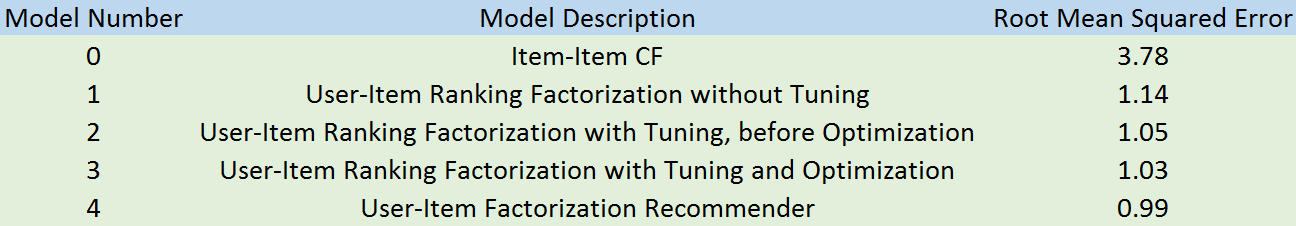

In [1130]:
from IPython.display import Image
PATH = "C:/Users/DM/"
Image(filename = PATH + "model_Review.png", width=800, height=800)

#### With Model 4 having the lowest Root Mean Squared Error, the User-Item Factorization Recommender is selected as the best model for the Movielens dataset.

## Section 4: Association Rule Mining

Below, we can identify the frequent patterns of MovieLens users to see which movies were most frequently watched together. 

- The most frequent 4 movie pattern was: "Jurassic Park (1993)', 'Matrix, The (1999)', 'Men in Black (1997)', 'Total Recall (1990)'" having been watched by 1202 users. 

- The most frequent 2 movie pattern was from the 1153 users who watched 'Back to the Future Part II', 1061 users watched 'Back to the Future'. This equates to a 92% confidence of those who watched 'Back to the Future Part II' will watch 'Back to the Future'.

In [1102]:
# Build a frequent pattern miner model.
rule_model = gl.frequent_pattern_mining.create(train, 'movie',
                features=['user'], min_length=4, max_patterns=500)


# Obtain the most frequent patterns.
patterns = rule_model.get_frequent_patterns()

# Extract features from the dataset and use in other models!
features = rule_model.extract_features(train)


# Make predictions based on frequent patterns.
predictions = rule_model.predict(test)

Indexing complete. Found 3512 unique items.

Preprocessing complete. Found 6040 unique transactions.

Building frequent pattern tree.

+-----------+----------------+------------+----------------------+------------------+

| Iteration | Num. Patterns  | Support    | Current Min Support  | Elapsed Time     |

+-----------+----------------+------------+----------------------+------------------+

| 0         | 0              | 3420       | 7                    | 0us              |

| 1         | 0              | 2662       | 7                    | 502us            |

| 2         | 0              | 2650       | 7                    | 502us            |

| 3         | 0              | 2582       | 7                    | 502us            |

| 4         | 1              | 2575       | 7                    | 502us            |

| 5         | 6              | 2567       | 7                    | 502us            |

| 6         | 22             | 2530       | 7                    | 502us            |

| 7         | 64             | 2509       | 7                    | 1.504ms          |

| 8         | 163            | 2507       | 7                    | 3.009ms          |

| 9         | 382            | 2452       | 7                    | 9.025ms          |

| 10        | 500            | 2430       | 581                  | 350.584ms        |

| 11        | 500            | 2362       | 658                  | 389.707ms        |

| 12        | 500            | 2312       | 679                  | 421.291ms        |

| 13        | 500            | 2298       | 707                  | 469.419ms        |

| 14        | 500            | 2279       | 724                  | 504.513ms        |

| 15        | 500            | 2270       | 741                  | 557.654ms        |

| 16        | 500            | 2258       | 755                  | 617.814ms        |

| 17        | 500            | 2231       | 765                  | 668.448ms        |

| 18        | 500            | 2219       | 768                  | 698.529ms        |

| 19        | 500            | 2217       | 783                  | 782.253ms        |

| 20        | 500            | 2185       | 784                  | 825.366ms        |

| 21        | 500            | 2173       | 786                  | 885.024ms        |

| 22        | 500            | 2164       | 788                  | 949.711ms        |

| 23        | 500            | 2092       | 805                  | 1.07s            |

| 24        | 500            | 2072       | 811                  | 1.14s            |

| 25        | 500            | 2017       | 812                  | 1.20s            |

| 26        | 500            | 1990       | 815                  | 1.26s            |

| 27        | 500            | 1986       | 827                  | 1.38s            |

| 28        | 500            | 1919       | 834                  | 1.46s            |

| 29        | 500            | 1814       | 834                  | 1.51s            |

| 30        | 500            | 1792       | 841                  | 1.61s            |

| 31        | 500            | 1791       | 841                  | 1.68s            |

| 32        | 500            | 1783       | 843                  | 1.75s            |

| 33        | 500            | 1780       | 843                  | 1.83s            |

| 34        | 500            | 1746       | 846                  | 1.93s            |

| 35        | 500            | 1726       | 846                  | 1.98s            |

| 36        | 500            | 1723       | 848                  | 2.06s            |

| 37        | 500            | 1722       | 848                  | 2.12s            |

| 38        | 500            | 1720       | 848                  | 2.14s            |

| 39        | 500            | 1713       | 848                  | 2.18s            |

| 40        | 500            | 1711       | 848                  | 2.25s            |

| 41        | 500            | 1695       | 849                  | 2.31s            |

| 42        | 500            | 1691       | 849                  | 2.34s            |

| 43        | 500            | 1666       | 849                  | 2.42s            |

| 44        | 500            | 1659       | 849                  | 2.45s            |

| 45        | 500            | 1654       | 851                  | 2.54s            |

| 46        | 500            | 1644       | 851                  | 2.59s            |

| 47        | 500            | 1644       | 852                  | 2.67s            |

| 48        | 500            | 1624       | 853                  | 2.73s            |

| 49        | 500            | 1621       | 853                  | 2.82s            |

| 50        | 500            | 1593       | 855                  | 2.94s            |

| 51        | 500            | 1579       | 855                  | 3.01s            |

| 52        | 500            | 1564       | 855                  | 3.04s            |

| 53        | 500            | 1542       | 855                  | 3.09s            |

| 54        | 500            | 1539       | 855                  | 3.14s            |

| 55        | 500            | 1531       | 855                  | 3.16s            |

| 56        | 500            | 1518       | 855                  | 3.20s            |

| 57        | 500            | 1508       | 855                  | 3.22s            |

| 58        | 500            | 1504       | 855                  | 3.27s            |

| 59        | 500            | 1488       | 855                  | 3.28s            |

| 60        | 500            | 1483       | 855                  | 3.32s            |

| 61        | 500            | 1466       | 855                  | 3.39s            |

| 62        | 500            | 1461       | 855                  | 3.46s            |

| 63        | 500            | 1447       | 855                  | 3.48s            |

| 64        | 500            | 1446       | 855                  | 3.50s            |

| 65        | 500            | 1443       | 855                  | 3.53s            |

| 66        | 500            | 1431       | 855                  | 3.56s            |

| 67        | 500            | 1427       | 855                  | 3.60s            |

| 68        | 500            | 1417       | 855                  | 3.66s            |

| 69        | 500            | 1414       | 855                  | 3.69s            |

| 70        | 500            | 1414       | 855                  | 3.72s            |

| 71        | 500            | 1414       | 856                  | 3.74s            |

| 72        | 500            | 1407       | 856                  | 3.76s            |

| 73        | 500            | 1398       | 856                  | 3.78s            |

| 74        | 500            | 1385       | 856                  | 3.80s            |

| 75        | 500            | 1377       | 856                  | 3.81s            |

| 76        | 500            | 1377       | 856                  | 3.82s            |

| 77        | 500            | 1370       | 856                  | 3.84s            |

| 78        | 500            | 1368       | 857                  | 3.85s            |

| 79        | 500            | 1367       | 857                  | 3.87s            |

| 80        | 500            | 1366       | 857                  | 3.88s            |

| 81        | 500            | 1355       | 857                  | 3.89s            |

| 82        | 500            | 1354       | 857                  | 3.90s            |

| 83        | 500            | 1352       | 857                  | 3.91s            |

| 84        | 500            | 1349       | 857                  | 3.93s            |

| 85        | 500            | 1349       | 857                  | 3.94s            |

| 86        | 500            | 1344       | 857                  | 3.95s            |

| 87        | 500            | 1335       | 857                  | 3.97s            |

| 88        | 500            | 1335       | 857                  | 3.99s            |

| 89        | 500            | 1330       | 857                  | 4.00s            |

| 90        | 500            | 1327       | 857                  | 4.01s            |

| 91        | 500            | 1326       | 857                  | 4.02s            |

| 92        | 500            | 1325       | 857                  | 4.03s            |

| 93        | 500            | 1324       | 857                  | 4.05s            |

| 94        | 500            | 1311       | 857                  | 4.06s            |

| 95        | 500            | 1309       | 857                  | 4.07s            |

| 96        | 500            | 1308       | 857                  | 4.08s            |

| 97        | 500            | 1294       | 857                  | 4.10s            |

| 98        | 500            | 1259       | 857                  | 4.11s            |

| 99        | 500            | 1258       | 857                  | 4.12s            |

| 100       | 500            | 1256       | 857                  | 4.13s            |

| 101       | 500            | 1249       | 857                  | 4.15s            |

| 102       | 500            | 1247       | 857                  | 4.16s            |

| 103       | 500            | 1238       | 857                  | 4.17s            |

| 104       | 500            | 1235       | 857                  | 4.18s            |

| 105       | 500            | 1234       | 857                  | 4.19s            |

| 106       | 500            | 1231       | 857                  | 4.20s            |

| 107       | 500            | 1230       | 857                  | 4.21s            |

| 108       | 500            | 1225       | 857                  | 4.22s            |

| 109       | 500            | 1223       | 857                  | 4.24s            |

| 110       | 500            | 1221       | 857                  | 4.25s            |

| 111       | 500            | 1221       | 857                  | 4.26s            |

| 112       | 500            | 1217       | 857                  | 4.27s            |

| 113       | 500            | 1216       | 857                  | 4.29s            |

| 114       | 500            | 1203       | 857                  | 4.30s            |

| 115       | 500            | 1194       | 857                  | 4.31s            |

| 116       | 500            | 1185       | 857                  | 4.32s            |

| 117       | 500            | 1180       | 857                  | 4.33s            |

| 118       | 500            | 1176       | 857                  | 4.34s            |

| 119       | 500            | 1175       | 857                  | 4.36s            |

| 120       | 500            | 1173       | 857                  | 4.37s            |

| 121       | 500            | 1159       | 857                  | 4.38s            |

| 122       | 500            | 1156       | 857                  | 4.39s            |

| 123       | 500            | 1155       | 857                  | 4.40s            |

| 124       | 500            | 1155       | 857                  | 4.42s            |

| 125       | 500            | 1153       | 857                  | 4.43s            |

| 126       | 500            | 1152       | 857                  | 4.44s            |

| 127       | 500            | 1149       | 857                  | 4.45s            |

| 128       | 500            | 1145       | 857                  | 4.46s            |

| 129       | 500            | 1139       | 857                  | 4.48s            |

| 130       | 500            | 1136       | 857                  | 4.49s            |

| 131       | 500            | 1132       | 857                  | 4.50s            |

| 132       | 500            | 1131       | 857                  | 4.52s            |

| 133       | 500            | 1127       | 857                  | 4.53s            |

| 134       | 500            | 1126       | 857                  | 4.55s            |

| 135       | 500            | 1123       | 857                  | 4.56s            |

| 136       | 500            | 1122       | 857                  | 4.58s            |

| 137       | 500            | 1119       | 857                  | 4.59s            |

| 138       | 500            | 1118       | 857                  | 4.61s            |

| 139       | 500            | 1116       | 857                  | 4.62s            |

| 140       | 500            | 1115       | 857                  | 4.63s            |

| 141       | 500            | 1113       | 857                  | 4.64s            |

| 142       | 500            | 1113       | 857                  | 4.65s            |

| 143       | 500            | 1112       | 857                  | 4.66s            |

| 144       | 500            | 1110       | 857                  | 4.68s            |

| 145       | 500            | 1107       | 857                  | 4.69s            |

| 146       | 500            | 1106       | 857                  | 4.70s            |

| 147       | 500            | 1106       | 857                  | 4.72s            |

| 148       | 500            | 1099       | 857                  | 4.74s            |

| 149       | 500            | 1096       | 857                  | 4.75s            |

| 150       | 500            | 1092       | 857                  | 4.76s            |

| 151       | 500            | 1091       | 857                  | 4.78s            |

| 152       | 500            | 1087       | 857                  | 4.79s            |

| 153       | 500            | 1084       | 857                  | 4.81s            |

| 154       | 500            | 1084       | 857                  | 4.82s            |

| 155       | 500            | 1082       | 857                  | 4.84s            |

| 156       | 500            | 1077       | 857                  | 4.85s            |

| 157       | 500            | 1074       | 857                  | 4.87s            |

| 158       | 500            | 1073       | 857                  | 4.88s            |

| 159       | 500            | 1070       | 857                  | 4.89s            |

| 160       | 500            | 1070       | 857                  | 4.91s            |

| 161       | 500            | 1066       | 857                  | 4.92s            |

| 162       | 500            | 1063       | 857                  | 4.94s            |

| 163       | 500            | 1062       | 857                  | 4.95s            |

| 164       | 500            | 1058       | 857                  | 4.96s            |

| 165       | 500            | 1058       | 857                  | 4.98s            |

| 166       | 500            | 1053       | 857                  | 4.99s            |

| 167       | 500            | 1052       | 857                  | 5.01s            |

| 168       | 500            | 1047       | 857                  | 5.02s            |

| 169       | 500            | 1046       | 857                  | 5.04s            |

| 170       | 500            | 1045       | 857                  | 5.05s            |

| 171       | 500            | 1045       | 857                  | 5.07s            |

| 172       | 500            | 1043       | 857                  | 5.08s            |

| 173       | 500            | 1041       | 857                  | 5.09s            |

| 174       | 500            | 1038       | 857                  | 5.11s            |

| 175       | 500            | 1031       | 857                  | 5.12s            |

| 176       | 500            | 1029       | 857                  | 5.14s            |

| 177       | 500            | 1027       | 857                  | 5.15s            |

| 178       | 500            | 1027       | 857                  | 5.17s            |

| 179       | 500            | 1017       | 857                  | 5.18s            |

| 180       | 500            | 1011       | 857                  | 5.20s            |

| 181       | 500            | 1009       | 857                  | 5.21s            |

| 182       | 500            | 1009       | 857                  | 5.23s            |

| 183       | 500            | 1008       | 857                  | 5.24s            |

| 184       | 500            | 1006       | 857                  | 5.26s            |

| 185       | 500            | 1005       | 857                  | 5.27s            |

| 186       | 500            | 1003       | 857                  | 5.29s            |

| 187       | 500            | 1002       | 857                  | 5.30s            |

| 188       | 500            | 997        | 857                  | 5.32s            |

| 189       | 500            | 994        | 857                  | 5.33s            |

| 190       | 500            | 994        | 857                  | 5.34s            |

| 191       | 500            | 990        | 857                  | 5.35s            |

| 192       | 500            | 986        | 857                  | 5.37s            |

| 193       | 500            | 986        | 857                  | 5.38s            |

| 194       | 500            | 986        | 857                  | 5.40s            |

| 195       | 500            | 984        | 857                  | 5.41s            |

| 196       | 500            | 983        | 857                  | 5.42s            |

| 197       | 500            | 980        | 857                  | 5.44s            |

| 198       | 500            | 978        | 857                  | 5.45s            |

| 199       | 500            | 975        | 857                  | 5.46s            |

| 200       | 500            | 974        | 857                  | 5.47s            |

| 201       | 500            | 973        | 857                  | 5.49s            |

| 202       | 500            | 967        | 857                  | 5.50s            |

| 203       | 500            | 965        | 857                  | 5.51s            |

| 204       | 500            | 963        | 857                  | 5.53s            |

| 205       | 500            | 962        | 857                  | 5.54s            |

| 206       | 500            | 949        | 857                  | 5.56s            |

| 207       | 500            | 946        | 857                  | 5.57s            |

| 208       | 500            | 943        | 857                  | 5.59s            |

| 209       | 500            | 943        | 857                  | 5.60s            |

| 210       | 500            | 943        | 857                  | 5.62s            |

| 211       | 500            | 942        | 857                  | 5.63s            |

| 212       | 500            | 941        | 857                  | 5.64s            |

| 213       | 500            | 936        | 857                  | 5.66s            |

| 214       | 500            | 935        | 857                  | 5.67s            |

| 215       | 500            | 934        | 857                  | 5.69s            |

| 216       | 500            | 933        | 857                  | 5.70s            |

| 217       | 500            | 931        | 857                  | 5.71s            |

| 218       | 500            | 928        | 857                  | 5.73s            |

| 219       | 500            | 927        | 857                  | 5.74s            |

| 220       | 500            | 926        | 857                  | 5.75s            |

| 221       | 500            | 924        | 857                  | 5.76s            |

| 222       | 500            | 924        | 857                  | 5.78s            |

| 223       | 500            | 921        | 857                  | 5.79s            |

| 224       | 500            | 911        | 857                  | 5.81s            |

| 225       | 500            | 911        | 857                  | 5.83s            |

| 226       | 500            | 910        | 857                  | 5.84s            |

| 227       | 500            | 909        | 857                  | 5.86s            |

| 228       | 500            | 907        | 857                  | 5.87s            |

| 229       | 500            | 905        | 857                  | 5.89s            |

| 230       | 500            | 905        | 857                  | 5.90s            |

| 231       | 500            | 902        | 857                  | 5.91s            |

| 232       | 500            | 901        | 857                  | 5.93s            |

| 233       | 500            | 899        | 857                  | 5.94s            |

| 234       | 500            | 893        | 857                  | 5.96s            |

| 235       | 500            | 893        | 857                  | 5.97s            |

| 236       | 500            | 892        | 857                  | 5.98s            |

| 237       | 500            | 886        | 857                  | 5.99s            |

| 238       | 500            | 884        | 857                  | 6.01s            |

| 239       | 500            | 882        | 857                  | 6.02s            |

| 240       | 500            | 882        | 857                  | 6.04s            |

| 241       | 500            | 882        | 857                  | 6.05s            |

| 242       | 500            | 881        | 857                  | 6.07s            |

| 243       | 500            | 881        | 857                  | 6.09s            |

| 244       | 500            | 881        | 857                  | 6.10s            |

| 245       | 500            | 880        | 857                  | 6.11s            |

| 246       | 500            | 880        | 857                  | 6.13s            |

| 247       | 500            | 875        | 857                  | 6.14s            |

| 248       | 500            | 873        | 857                  | 6.16s            |

| 249       | 500            | 869        | 857                  | 6.17s            |

| 250       | 500            | 869        | 857                  | 6.19s            |

| 251       | 500            | 866        | 857                  | 6.20s            |

| 252       | 500            | 865        | 857                  | 6.21s            |

| 253       | 500            | 862        | 857                  | 6.23s            |

| 254       | 500            | 861        | 857                  | 6.24s            |

| 255       | 500            | 859        | 857                  | 6.26s            |

| 256       | 500            | 859        | 857                  | 6.27s            |

| 257       | 500            | 859        | 857                  | 6.29s            |

| 258       | 500            | 858        | 857                  | 6.30s            |

| Final     | 500            | -          | 857                  | 6.31s            |

+-----------+----------------+------------+----------------------+------------------+

Pattern mining complete. Found 500 unique closed patterns.

Preprocessing complete. Found 6040 unique transactions.

Preprocessing complete. Found 100 unique transactions.

### Most Frequent Movie Patterns

In [1124]:
rule_model.summary()

Class                          : FrequentPatternMiner

Model fields
------------
Min support                    : 1
Max patterns                   : 500
Min pattern length             : 4

Most frequent patterns
----------------------
['Jurassic Park (1993)', 'Matrix, The (1999)', 'Men in Black (1997)', 'Total Recall (1990)'] : 1202
['American Beauty (1999)', 'Silence of the Lambs, The (1991)', 'Fargo (1996)', 'Pulp Fiction (1994)'] : 1106
['Jurassic Park (1993)', 'Matrix, The (1999)', 'Men in Black (1997)', 'Independence Day (ID4) (1996)'] : 1105
['Jurassic Park (1993)', 'Saving Private Ryan (1998)', 'Matrix, The (1999)', 'Men in Black (1997)'] : 1092
['American Beauty (1999)', 'Silence of the Lambs, The (1991)', 'Fargo (1996)', 'Shawshank Redemption, The (1994)'] : 1087
['Jurassic Park (1993)', 'Matrix, The (1999)', 'Back to the Future (1985)', 'Men in Black (1997)'] : 1072
['Jurassic Park (1993)', 'Matrix, The (1999)', 'Men in Black (1997)', 'Terminator, The (1984)'] : 1072
['Jurass

### Association Rules

In [1169]:
predictions.print_rows(num_rows=6, max_column_width=110)

+------+------------------------------------------------------------+-----------------------------+
| user |                           prefix                           |          prediction         |
+------+------------------------------------------------------------+-----------------------------+
| 5021 |            [Back to the Future Part II (1989)]             | [Back to the Future (1985)] |
| 5893 |              [When Harry Met Sally... (1989)]              | [Back to the Future (1985)] |
| 696  |        [Predator (1987), Back to the Future (1985)]        |   [Terminator, The (1984)]  |
| 578  |                    [Sling Blade (1996)]                    |        [Fargo (1996)]       |
| 521  |                [Dances with Wolves (1990)]                 |    [Jurassic Park (1993)]   |
| 5511 | [Fifth Element, The (1997), Independence Day (ID4) (1996)] |    [Men in Black (1997)]    |
+------+------------------------------------------------------------+-----------------------------+


### Conclusion:


#### Data Review
We reviewed the demographics of the users along with the trends in the ratings of movies. We found the users to be predominantly middle aged, with an over 2:1 ratio of men to women and most frequently residing in the Pacific region.  

#### Recommender System
In final review of the Movielens dataset, we selected the User-Item Factorization Recommender System from five models, with a RMSE of .99 after cross-validation. This model significantly improved the RMSE of the initial item-item model having a RMSE of 3.78 and the first user-item model having a RMSE of 1.14.

#### Association Rule Mining
We found the most frequent movie pattern from users and the most frequent association rules from users.
    
    
    -An example of one of the association rules we found was that from those who watched Back to the Future Part II, there is 92% confidence that those users will also watch Back to the Future. 